## NYC 311 CALLS DATA

In [1]:
import pandas as pd
import statsmodels.api as sm
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt


/Users/nikitaakenkre/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Reading the pickle file of data set

calls_df = pd.read_pickle("~/Downloads/Project-3_NYC_311_Calls.pkl")

calls_df


,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,City,Resolution Description,Borough,Open Data Channel Type
0,20184537,2011-04-06 00:00:00,HPD,Department of Housing Preservation and Develop...,HEATING,HEAT,RESIDENTIAL BUILDING,10002.0,NEW YORK,More than one complaint was received for this ...,MANHATTAN,UNKNOWN
1,20184538,2011-04-06 00:00:00,HPD,Department of Housing Preservation and Develop...,GENERAL CONSTRUCTION,WINDOWS,RESIDENTIAL BUILDING,11236.0,BROOKLYN,The Department of Housing Preservation and Dev...,BROOKLYN,UNKNOWN
2,20184539,2011-04-06 00:00:00,HPD,Department of Housing Preservation and Develop...,PAINT - PLASTER,WALLS,RESIDENTIAL BUILDING,10460.0,BRONX,The Department of Housing Preservation and Dev...,BRONX,UNKNOWN
3,54732265,2022-07-08 11:14:43,DSNY,Department of Sanitation,Dirty Condition,Trash,Sidewalk,10467.0,BRONX,The Department of Sanitation investigated this...,BRONX,PHONE
4,20184540,2011-04-06 00:00:00,HPD,Department of Housing Preservation and Develop...,NONCONST,VERMIN,RESIDENTIAL BUILDING,10460.0,BRONX,The Department of Housing Preservation and Dev...,BRONX,UNKNOWN
...,...,...,...,...,...,...,...,...,...,...,...,...
33780972,20184532,2011-04-06 00:00:00,HPD,Department of Housing Preservation and Develop...,HEATING,HEAT,RESIDENTIAL BUILDING,10468,BRONX,The Department of Housing Preservation and Dev...,BRONX,UNKNOWN
33780973,20184533,2011-04-06 00:00:00,HPD,Department of Housing Preservation and Develop...,HEATING,HEAT,RESIDENTIAL BUILDING,10018,NEW YORK,More than one complaint was received for this ...,MANHATTAN,UNKNOWN
33780974,20184534,2011-04-06 00:00:00,HPD,Department of Housing Preservation and Develop...,GENERAL CONSTRUCTION,STAIRS,RESIDENTIAL BUILDING,10460,BRONX,The Department of Housing Preservation and Dev...,BRONX,UNKNOWN
33780975,20184535,2011-04-06 00:00:00,HPD,Department of Housing Preservation and Develop...,GENERAL CONSTRUCTION,GAS,RESIDENTIAL BUILDING,11236,BROOKLYN,The Department of Housing Preservation and Dev...,BROOKLYN,UNKNOWN


### EXPLORATORY DATA ANALYSIS

In [3]:
# Finding the distinct values in each column
distinct_values_count = calls_df.nunique()

distinct_values_count

Unique Key                33780977
Created Date              23399452
Agency                          36
Agency Name                   1888
Complaint Type                 485
Descriptor                    1933
Location Type                  230
Incident Zip                  3711
City                          2749
Resolution Description        1978
Borough                          6
Open Data Channel Type           5
dtype: int64

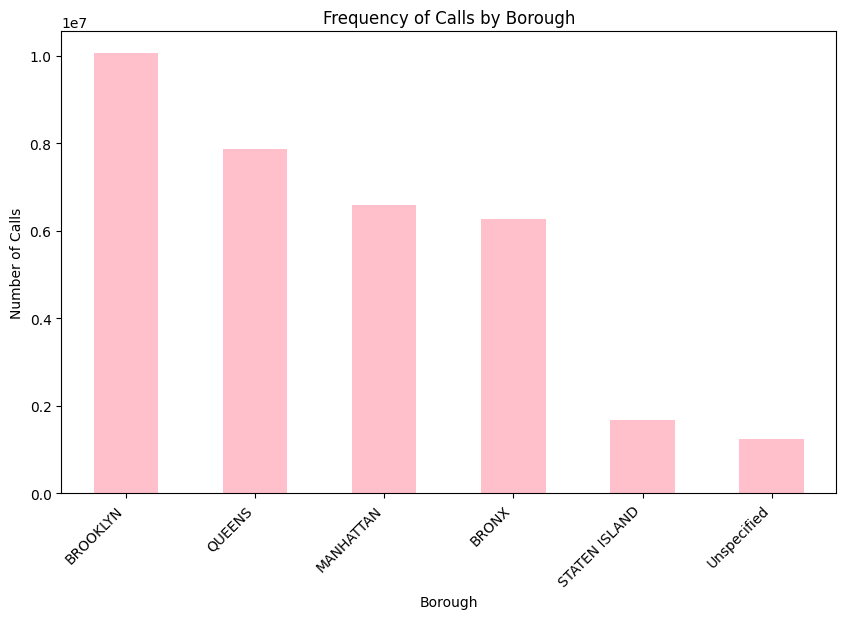

In [4]:
borough_counts = calls_df['Borough'].value_counts()

# Plotting a bar graph
plt.figure(figsize=(10, 6))
borough_counts.plot(kind='bar', color='pink')
plt.title('Frequency of Calls by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [6]:
# Convert 'DateTimeColumn' to datetime format if it's not already
calls_df['Created Date'] = pd.to_datetime(calls_df['Created Date'])

# Split the 'DateTimeColumn' into separate 'Date' and 'Day' columns
calls_df['Date of Call'] = calls_df['Created Date'].dt.date
calls_df['Day of Call'] = calls_df['Created Date'].dt.strftime('%A')
calls_df['Time of Call'] = calls_df['Created Date'].dt.strftime('%H:%M:%S')

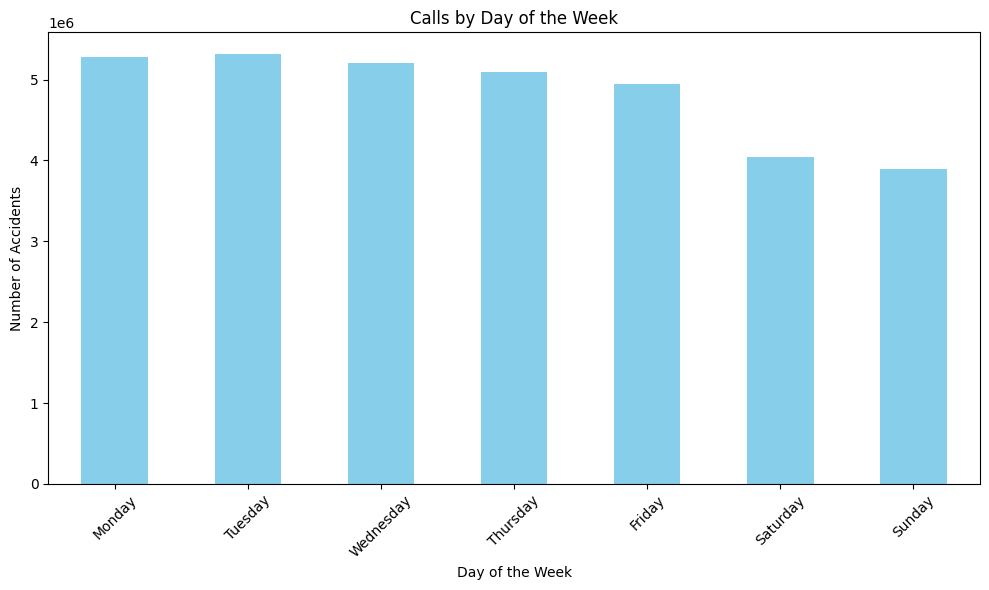

In [7]:
# Define the order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group the data by 'Day' and count the number of occurrences
calls_by_day = calls_df['Day of Call'].value_counts().sort_index()

# Reorder the index based on the specified day_order
calls_by_day = calls_by_day.reindex(day_order, fill_value=0)

# Create a bar plot
plt.figure(figsize=(10, 6))
calls_by_day.plot(kind='bar', color='skyblue')
plt.title('Calls by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.tight_layout()
plt.show()

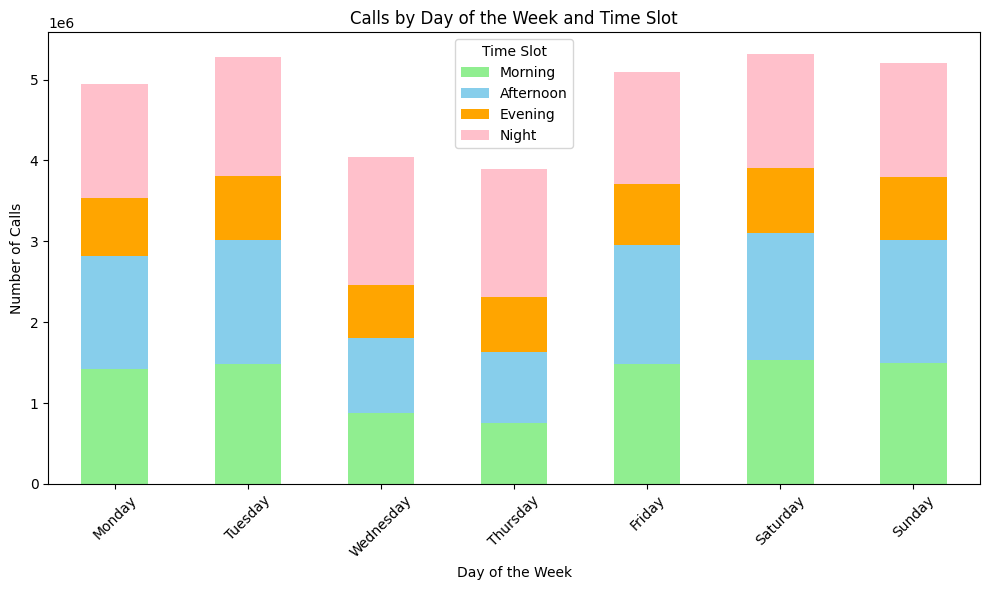

In [8]:
# Convert the 'Time' column to a datetime format
calls_df['Time of Call'] = pd.to_datetime(calls_df['Time of Call'], format='%H:%M:%S').dt.time

# Extract the hour from the 'Time' column
calls_df['Hour of Call'] = calls_df['Time of Call'].apply(lambda x: x.hour)

# Create a function to categorize time into slots
def categorize_time(time):
    if 5 <= time.hour < 12:
        return "Morning"
    elif 12 <= time.hour < 17:
        return "Afternoon"
    elif 17 <= time.hour < 21:
        return "Evening"
    else:
        return "Night"

# Create new columns for time slot and day of the week
calls_df['TimeSlot'] = calls_df['Time of Call'].apply(categorize_time)

# Group by 'DayOfWeek' and 'TimeSlot' and count the accidents
grouped = calls_df.groupby(['Day of Call', 'TimeSlot']).size().unstack(fill_value=0)

# Reorder columns to have them in a logical order
column_order = ['Morning', 'Afternoon', 'Evening', 'Night']
grouped = grouped[column_order]

# Define custom colors for each time slot
colors = ['lightgreen', 'skyblue', 'orange', 'pink']

# Create a bar chart with custom colors
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Set labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Number of Calls')
plt.title('Calls by Day of the Week and Time Slot')

# Customize the x-axis labels
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(range(len(days_of_week)), days_of_week, rotation=45)

# Show the legend
plt.legend(title='Time Slot')

# Display the plot
plt.tight_layout()
plt.show()

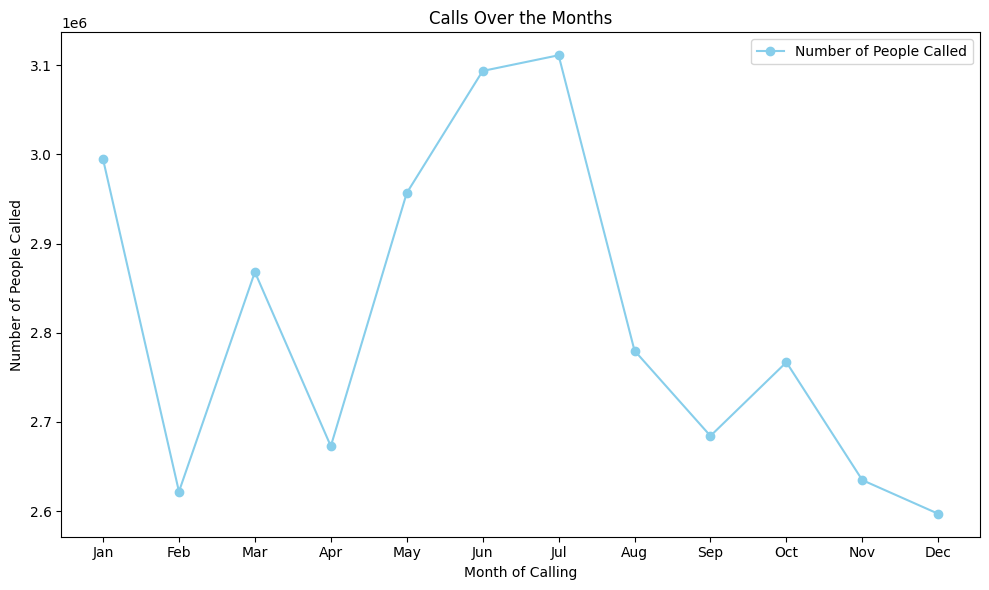

In [10]:
# Convert the 'Date' column to a datetime object if it's not already in datetime format
calls_df['Date of Call'] = pd.to_datetime(calls_df['Date of Call'])

# Extract the month from the 'Date' column and create a new column 'Month'
calls_df['Month'] = calls_df['Date of Call'].dt.month

# Group the data by 'Month' and sum the number of people called in each month
calls_by_month = calls_df.groupby('Month')['Unique Key'].count()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(calls_by_month.index, calls_by_month.values, marker='o', linestyle='-',
         color='skyblue', markersize=6, label='Number of People Called')

# Set the x-axis ticks to display each month from January to December
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.title('Calls Over the Months')
plt.xlabel('Month of Calling')
plt.ylabel('Number of People Called')
plt.grid(False)  # Add a grid for better readability
plt.legend()  # Show a legend

# Show the plot
plt.tight_layout()
plt.show()

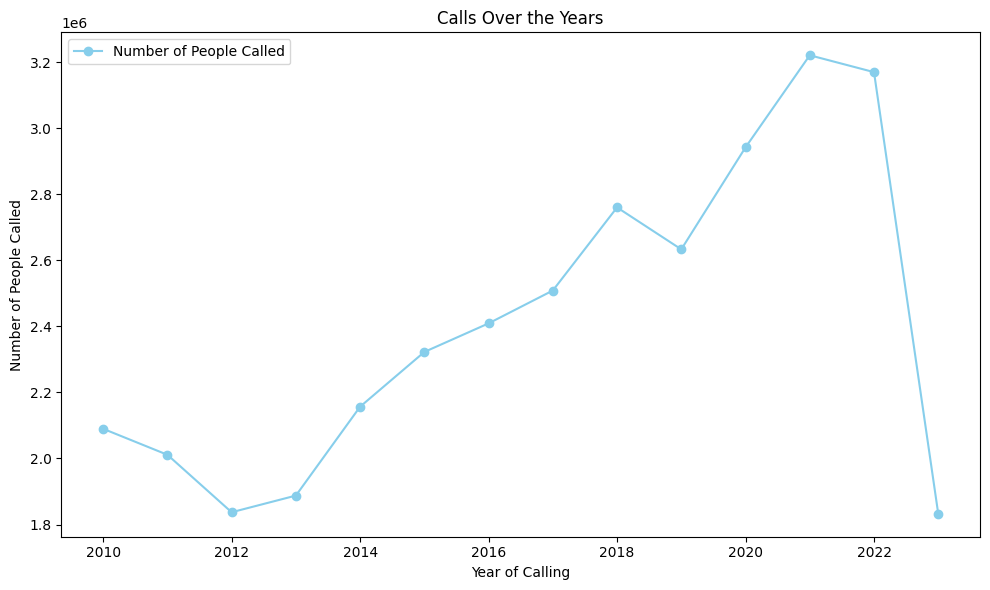

In [11]:
# Convert the 'Date' column to a datetime object if it's not already in datetime format
calls_df['Date of Call'] = pd.to_datetime(calls_df['Date of Call'])

# Extract the year from the 'Date' column and create a new column 'Year'
calls_df['Year'] = calls_df['Date of Call'].dt.year

# Group the data by 'Year' and sum the number of people called in each year
calls_by_year = calls_df.groupby('Year')['Unique Key'].count()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(calls_by_year.index, calls_by_year.values, marker='o', linestyle='-',
         color='skyblue', markersize=6, label='Number of People Called')
plt.title('Calls Over the Years')
plt.xlabel('Year of Calling')
plt.ylabel('Number of People Called')
plt.grid(False)  # Add a grid for better readability
plt.legend()  # Show a legend

# Show the plot
plt.tight_layout()
plt.show()

### Resampling the data for ease of analysis - Markdown

In [12]:
calls_df = calls_df.set_index(pd.DatetimeIndex(calls_df['Created Date']))
del calls_df['Created Date']

calls_df

,Unique Key,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,City,Resolution Description,Borough,Open Data Channel Type,Date of Call,Day of Call,Time of Call,Hour of Call,TimeSlot,Month,Year
Created Date,,,,,,,,,,,,,,,,,,
2011-04-06 00:00:00,20184537,HPD,Department of Housing Preservation and Develop...,HEATING,HEAT,RESIDENTIAL BUILDING,10002.0,NEW YORK,More than one complaint was received for this ...,MANHATTAN,UNKNOWN,2011-04-06,Wednesday,00:00:00,0,Night,4,2011
2011-04-06 00:00:00,20184538,HPD,Department of Housing Preservation and Develop...,GENERAL CONSTRUCTION,WINDOWS,RESIDENTIAL BUILDING,11236.0,BROOKLYN,The Department of Housing Preservation and Dev...,BROOKLYN,UNKNOWN,2011-04-06,Wednesday,00:00:00,0,Night,4,2011
2011-04-06 00:00:00,20184539,HPD,Department of Housing Preservation and Develop...,PAINT - PLASTER,WALLS,RESIDENTIAL BUILDING,10460.0,BRONX,The Department of Housing Preservation and Dev...,BRONX,UNKNOWN,2011-04-06,Wednesday,00:00:00,0,Night,4,2011
2022-07-08 11:14:43,54732265,DSNY,Department of Sanitation,Dirty Condition,Trash,Sidewalk,10467.0,BRONX,The Department of Sanitation investigated this...,BRONX,PHONE,2022-07-08,Friday,11:14:43,11,Morning,7,2022
2011-04-06 00:00:00,20184540,HPD,Department of Housing Preservation and Develop...,NONCONST,VERMIN,RESIDENTIAL BUILDING,10460.0,BRONX,The Department of Housing Preservation and Dev...,BRONX,UNKNOWN,2011-04-06,Wednesday,00:00:00,0,Night,4,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-04-06 00:00:00,20184532,HPD,Department of Housing Preservation and Develop...,HEATING,HEAT,RESIDENTIAL BUILDING,10468,BRONX,The Department of Housing Preservation and Dev...,BRONX,UNKNOWN,2011-04-06,Wednesday,00:00:00,0,Night,4,2011
2011-04-06 00:00:00,20184533,HPD,Department of Housing Preservation and Develop...,HEATING,HEAT,RESIDENTIAL BUILDING,10018,NEW YORK,More than one complaint was received for this ...,MANHATTAN,UNKNOWN,2011-04-06,Wednesday,00:00:00,0,Night,4,2011
2011-04-06 00:00:00,20184534,HPD,Department of Housing Preservation and Develop...,GENERAL CONSTRUCTION,STAIRS,RESIDENTIAL BUILDING,10460,BRONX,The Department of Housing Preservation and Dev...,BRONX,UNKNOWN,2011-04-06,Wednesday,00:00:00,0,Night,4,2011


### Question 1

##### We start with looking at the average complaints received in 2022

In [13]:
# Filter data for the year 2022
calls_df_2022 = calls_df[calls_df.index.year == 2022]

# Resample data to daily frequency and count the number of complaints for each day
daily_complaints_2022 = calls_df_2022['Unique Key'].resample('D').count()

# Calculate the average number of daily complaints in 2022
average_daily_complaints_2022 = daily_complaints_2022.mean()

# Print the result
print("Average number of daily complaints received in 2022:", average_daily_complaints_2022)

Average number of daily complaints received in 2022: 8684.320547945206



### Question 2

##### We then look at which date had the maximum number of calls

In [14]:
# Count the number of complaints for each date
daily_complaints = calls_df['Unique Key'].resample('D').count()

# Find the date with the maximum number of calls
date_with_max_calls = daily_complaints.idxmax()

# Find the maximum number of calls
max_calls = daily_complaints.max()

# Print the result
print("On", date_with_max_calls.strftime('%Y-%m-%d'), "the maximum number of calls (", max_calls, ") were received.")

On 2020-08-04 the maximum number of calls ( 24415 ) were received.


### Question 3

##### Our next concern is to see what is the most important and frequent complaint of the people

In [15]:
# Filter the DataFrame for the date with the maximum number of calls
max_calls_date_df = calls_df[calls_df.index.date == date_with_max_calls.date()]

# Find the most important complaint type on that date
most_important_complaint_type = max_calls_date_df['Complaint Type'].value_counts().idxmax()

# Print the result
print("On", date_with_max_calls.strftime('%Y-%m-%d'), "the most important complaint type was:", most_important_complaint_type)

On 2020-08-04 the most important complaint type was: Damaged Tree



### Question 4

##### We would also like to know which month had the least calls

In [17]:
# Group by month, count the number of calls, and find the month with the minimum calls
quietest_month = calls_df.groupby([calls_df.Month])['Unique Key'].count().idxmin()

# Print the result
print("The quietest month historically with the fewest number of calls is:", pd.to_datetime(quietest_month, format='%m').strftime("%B"))

The quietest month historically with the fewest number of calls is: December


### Question 5

##### Now we resample the time series to a daily frequency and perform ETS decomposition based on an additive model.  Then we find the value of the seasonal component on 2020-12-25.

In [18]:
# Resample data to daily frequency
daily_complaints = calls_df['Unique Key'].resample('D').count()

# Perform ETS decomposition
result = sm.tsa.seasonal_decompose(daily_complaints, model='additive')

# Extract the seasonal component
seasonal_component = result.seasonal

# Find the value of the seasonal component on 2020-12-25
value_on_2020_12_25 = round(seasonal_component['2020-12-25'])

# Print the result
print("The value of the seasonal component on 2020-12-25 (rounded to the nearest integer) is:", value_on_2020_12_25)

The value of the seasonal component on 2020-12-25 (rounded to the nearest integer) is: 183


### Question 6

##### Then we calculate the autocorrelation of the number of daily calls with the number of calls the day prior, ie lag of 1.

In [19]:
# Resample data to daily frequency
daily_complaints = calls_df['Unique Key'].resample('D').count()

# Calculate the autocorrelation with a lag of 1
autocorrelation_lag_1 = daily_complaints.autocorr(lag=1)

# Print the result
print("The autocorrelation of the number of daily calls with the number of calls the day prior is:", autocorrelation_lag_1)

The autocorrelation of the number of daily calls with the number of calls the day prior is: 0.7517059728398578


### Question 7

##### We finnaly forecast the daily series with a test set of 90 days using the Prophet library.  And analyze the RMSE on our test set.

In [20]:
# Resample data to daily frequency
daily_complaints = calls_df['Unique Key'].resample('D').count().reset_index()

# Rename columns as required by Prophet
daily_complaints.columns = ['ds', 'y']

# Split the data into training and test sets
train_data = daily_complaints[:-90]
test_data = daily_complaints[-90:]

# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_data)

# Create a DataFrame with the dates for the test set
future = model.make_future_dataframe(periods=90)

# Generate forecasts for the test set
forecast = model.predict(future)

# Extract the predicted values for the test set
y_pred = forecast[-90:]['yhat']

# Extract the actual values for the test set
y_true = test_data['y']

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_true, y_pred))

# Print the result
print("RMSE on the test set:", rmse)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


RMSE on the test set: 1231.3215094072907
